In [1]:
import os
import torch
import pandas as pd
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils

In [2]:
#!wget https://download.pytorch.org/tutorial/faces.zip

In [3]:
#!unzip faces.zip

In [4]:
ls

airline-passengers.csv  faces.zip.1           mnist_model.png
cralwer/                faces.zip.2           model_info.png
cralwer.zip             hymenoptera_data/     text-summarization/
faces/                  hymenoptera_data.zip  未命名.ipynb
faces.zip               MachineLearningCVE/


In [5]:
landmark_f=pd.read_csv('faces/face_landmarks.csv')

n=65
img_name=landmark_f.iloc[n,0]
landmarks=landmark_f.iloc[n,1:].as_matrix()
landmarks=landmarks.astype('float').reshape(-1,2)
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


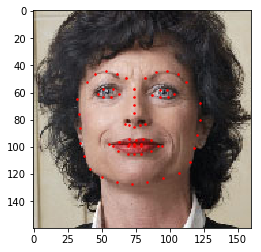

In [6]:
def show_landmarks(img,landmark):
    plt.imshow(img)
    plt.scatter(landmarks[:,0],landmarks[:,1],s=10,marker='.',c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('faces/',img_name)),landmarks)
plt.show()

In [7]:
class Datasets(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.landmark_f=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
    def __len__(self):
        return len(self.landmark_f)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmark_f.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmark_f.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


0 (324, 215, 3) (68, 2)


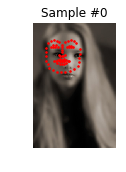

1 (500, 333, 3) (68, 2)


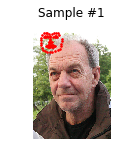

2 (250, 258, 3) (68, 2)


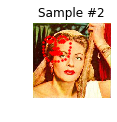

3 (434, 290, 3) (68, 2)


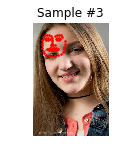

In [8]:
face_dataset = Datasets(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'],sample['landmarks'])

    if i == 3:
        plt.show()
        break

/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


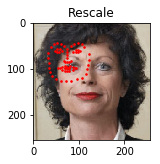

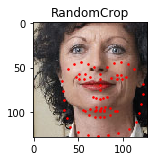

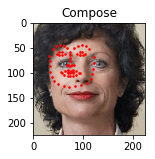

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(transformed_sample['image'],transformed_sample['landmarks'])

plt.show()

In [ ]:
transformed_dataset = Datasets(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/home/prozx/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


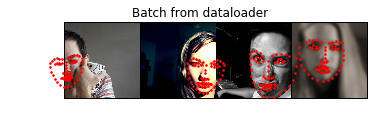

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [ ]:
'''import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='faces/',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)'''

"import torch\nfrom torchvision import transforms, datasets\n\ndata_transform = transforms.Compose([\n        transforms.RandomSizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                             std=[0.229, 0.224, 0.225])\n    ])\nhymenoptera_dataset = datasets.ImageFolder(root='faces/',\n                                           transform=data_transform)\ndataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,\n                                             batch_size=4, shuffle=True,\n                                             num_workers=4)"

In [ ]:
import torch 
dtype=torch.float
device=torch.device("cuda:0")

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)
learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 36349568.0
1 30780676.0
2 28145688.0
3 23881530.0
4 17718104.0
5 11387424.0
6 6747009.0
7 3925856.0
8 2406489.5
9 1596662.75
10 1150647.625
11 884230.75
12 710329.75
13 587113.25
14 494276.375
15 421298.1875
16 362304.15625
17 313691.65625
18 273166.875
19 239060.3125
20 210124.21875
21 185419.046875
22 164212.84375
23 145936.0
24 130128.484375
25 116356.96875
26 104325.765625
27 93774.8515625
28 84492.34375
29 76305.65625
30 69063.765625
31 62635.7265625
32 56910.40625
33 51805.69140625
34 47243.71484375
35 43152.5390625
36 39476.4609375
37 36164.2109375
38 33175.0859375
39 30472.703125
40 28025.2265625
41 25804.3984375
42 23787.2109375
43 21950.92578125
44 20279.375
45 18753.65234375
46 17360.19140625
47 16084.8623046875
48 14916.9091796875
49 13850.5302734375
50 12871.646484375
51 11971.515625
52 11143.326171875
53 10380.576171875
54 9677.380859375
55 9028.1181640625
56 8428.3955078125
57 7874.501953125
58 7362.53515625
59 6888.2158203125
60 6448.6484375
61 6040.87353515625
62 566

382 0.018769396468997
383 0.01818213239312172
384 0.01762586273252964
385 0.017088385298848152
386 0.01656154729425907
387 0.016055356711149216
388 0.015568366274237633
389 0.015094525180757046
390 0.014632310718297958
391 0.01418319996446371
392 0.013754729181528091
393 0.013331920839846134
394 0.012927941046655178
395 0.012538949958980083
396 0.012159690260887146
397 0.011800636537373066
398 0.011441324837505817
399 0.011093801818788052
400 0.010760815814137459
401 0.010438669472932816
402 0.0101261455565691
403 0.009820356033742428
404 0.009527701884508133
405 0.009243424981832504
406 0.008967911824584007
407 0.008700378239154816
408 0.008442099206149578
409 0.00819049309939146
410 0.007951200939714909
411 0.007713490165770054
412 0.007485705427825451
413 0.007267412729561329
414 0.007054896093904972
415 0.006852721329778433
416 0.006652935408055782
417 0.006458799354732037
418 0.00627202820032835
419 0.006090614013373852
420 0.005915602203458548
421 0.005744406022131443
422 0.00558

In [ ]:
class MyRelu(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input
dtype=torch.float
device=torch.device("cuda:0")
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # To apply our Function, we use Function.apply method. We alias this as 'relu'.
    relu = MyRelu.apply

    # Forward pass: compute predicted y using operations; we compute
    # ReLU using our custom autograd operation.
    y_pred = relu(x.mm(w1)).mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

0 26750498.0
1 22835304.0
2 21390062.0
3 19641652.0
4 16539900.0
5 12448980.0
6 8470986.0
7 5397570.0
8 3376386.5
9 2158831.5
10 1450659.625
11 1035468.8125
12 782724.875
13 619845.5
14 507848.25
15 426137.59375
16 363420.28125
17 313314.875
18 272352.1875
19 238176.0625
20 209271.546875
21 184595.78125
22 163387.15625
23 145056.625
24 129124.1640625
25 115202.390625
26 103013.6640625
27 92325.421875
28 82906.515625
29 74579.125
30 67190.8671875
31 60623.85546875
32 54781.46875
33 49583.3046875
34 44936.828125
35 40772.96875
36 37037.703125
37 33681.84765625
38 30664.921875
39 27948.28515625
40 25495.74609375
41 23278.599609375
42 21273.24609375
43 19455.8125
44 17807.892578125
45 16310.5322265625
46 14949.73046875
47 13711.654296875
48 12584.7177734375
49 11557.9638671875
50 10620.8984375
51 9765.2021484375
52 8983.7080078125
53 8269.2001953125
54 7615.56005859375
55 7017.115234375
56 6468.7890625
57 5966.30615234375
58 5505.36572265625
59 5082.1552734375
60 4693.705078125
61 4337.629

443 5.09489509568084e-05
444 5.01839276694227e-05
445 4.956380871590227e-05
446 4.901242209598422e-05
447 4.850296681979671e-05
448 4.783256008522585e-05
449 4.697914846474305e-05
450 4.634048309526406e-05
451 4.581375833367929e-05
452 4.5236811274662614e-05
453 4.433179856278002e-05
454 4.3767475290223956e-05
455 4.329462899477221e-05
456 4.284920942154713e-05
457 4.2274525185348466e-05
458 4.1701074223965406e-05
459 4.113187605980784e-05
460 4.057867772644386e-05
461 4.006773087894544e-05
462 3.953459963668138e-05
463 3.9175407437141985e-05
464 3.886547347065061e-05
465 3.819147968897596e-05
466 3.770736657315865e-05
467 3.7193865864537656e-05
468 3.6818899388890713e-05
469 3.618196933530271e-05
470 3.57202734448947e-05
471 3.5451739677228034e-05
472 3.5092918551526964e-05
473 3.4596559999044985e-05
474 3.4193719329778105e-05
475 3.386047319509089e-05
476 3.355924127390608e-05
477 3.3089247153839096e-05
478 3.265099076088518e-05
479 3.234092946513556e-05
480 3.183986700605601e-05
481

In [ ]:
import torch
n,ins,h,out=64,1000,100,10
x=torch.randn(n,ins)
y=torch.randn(n,out)

model=torch.nn.Sequential(
        torch.nn.Linear(ins,h),
        torch.nn.ReLU(),
        torch.nn.Linear(h,out),
)

loss_fun=torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fun(y_pred, y)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 640.3427124023438
1 624.089111328125
2 608.2872314453125
3 592.9376831054688
4 578.0469970703125
5 563.5883178710938
6 549.6726684570312
7 536.1953125
8 523.13671875
9 510.4144287109375
10 498.0596618652344
11 486.067138671875
12 474.4134826660156
13 463.1133117675781
14 452.1905212402344
15 441.5316467285156
16 431.2566223144531
17 421.2823791503906
18 411.6286926269531
19 402.2281799316406
20 393.0939025878906
21 384.24658203125
22 375.67987060546875
23 367.31011962890625
24 359.1540832519531
25 351.18243408203125
26 343.3558654785156
27 335.70098876953125
28 328.224853515625
29 320.9058837890625
30 313.7523498535156
31 306.7621154785156
32 299.9386291503906
33 293.2637939453125
34 286.73126220703125
35 280.3515625
36 274.1061706542969
37 267.9689636230469
38 261.94598388671875
39 256.0286560058594
40 250.22579956054688
41 244.54345703125
42 238.96434020996094
43 233.51698303222656
44 228.17031860351562
45 222.93057250976562
46 217.79498291015625
47 212.7475128173828
48 207.7967834

382 0.00024292731541208923
383 0.0002316594182047993
384 0.00022090385027695447
385 0.0002106327301589772
386 0.00020082620903849602
387 0.00019147289276588708
388 0.0001825358485803008
389 0.00017400462820660323
390 0.00016586649871896952
391 0.00015809117758180946
392 0.00015067850472405553
393 0.00014359680062625557
394 0.00013684153964277357
395 0.00013040000339969993
396 0.00012425048043951392
397 0.0001183826316264458
398 0.00011278352758381516
399 0.0001074395258910954
400 0.0001023475851980038
401 9.74840295384638e-05
402 9.284774569096044e-05
403 8.842511306283996e-05
404 8.420935773756355e-05
405 8.018686639843509e-05
406 7.635002839379013e-05
407 7.26932194083929e-05
408 6.92046814947389e-05
409 6.587837560800835e-05
410 6.271110760280862e-05
411 5.968991536065005e-05
412 5.6809232773957774e-05
413 5.406342097558081e-05
414 5.1445207645883784e-05
415 4.895016536465846e-05
416 4.657352837966755e-05
417 4.4308279029792175e-05
418 4.215215449221432e-05
419 4.0093906136462465e-0

In [ ]:
import torch
class TwoLayer(torch.nn.Module):
    def __init__(self,D_in,H,D_out):
        super(TwoLayer,self).__init__()
        self.linear1=torch.nn.Linear(D_in,H)
        self.linear2=torch.nn.Linear(H,D_out)
    
    def forward(self,x):
        h_relu=self.linear1(x).clamp(min=0)
        y_pred=self.linear2(h_relu)
        return y_pred
    
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayer(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 692.7012939453125
1 639.9810791015625
2 594.8458862304688
3 555.3865356445312
4 520.5035400390625
5 489.34893798828125
6 461.1332092285156
7 435.27032470703125
8 411.35919189453125
9 389.0531005859375
10 367.98248291015625
11 348.2156982421875
12 329.826171875
13 312.431396484375
14 295.939453125
15 280.24639892578125
16 265.28314208984375
17 251.01007080078125
18 237.39419555664062
19 224.48037719726562
20 212.25613403320312
21 200.6622314453125
22 189.64663696289062
23 179.1989288330078
24 169.2284698486328
25 159.760009765625
26 150.7772216796875
27 142.26512145996094
28 134.23231506347656
29 126.6160888671875
30 119.40509033203125
31 112.5724868774414
32 106.1003189086914
33 99.96710205078125
34 94.1363754272461
35 88.6275863647461
36 83.42294311523438
37 78.5162353515625
38 73.89549255371094
39 69.53801727294922
40 65.4371109008789
41 61.58477783203125
42 57.95625305175781
43 54.54300308227539
44 51.335609436035156
45 48.32876968383789
46 45.50479507446289
47 42.85444259643555
4

373 0.00017880284576676786
374 0.00017358173499815166
375 0.00016851632972247899
376 0.00016359884466510266
377 0.00015883115702308714
378 0.00015420075214933604
379 0.00014970748452469707
380 0.0001453468285035342
381 0.00014111428754404187
382 0.00013700869749300182
383 0.0001330203958787024
384 0.00012915447587147355
385 0.00012539562885649502
386 0.0001217545650433749
387 0.00011821174120996147
388 0.00011477984662633389
389 0.00011145098687848076
390 0.00010821955947903916
391 0.0001050795181072317
392 0.000102029531262815
393 9.907243656925857e-05
394 9.619900083635002e-05
395 9.34145282371901e-05
396 9.070746455108747e-05
397 8.808408892946318e-05
398 8.553199586458504e-05
399 8.305652590934187e-05
400 8.065267320489511e-05
401 7.832146366126835e-05
402 7.6060023275204e-05
403 7.386357174254954e-05
404 7.17246366548352e-05
405 6.965541979297996e-05
406 6.764005229342729e-05
407 6.568791286554188e-05
408 6.3795865571592e-05
409 6.195385503815487e-05
410 6.016499537508935e-05
411 

In [ ]:
import random
import torch


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 705.9776611328125
1 695.9559326171875
2 705.0081176757812
3 702.9203491210938
4 672.5653686523438
5 696.8748168945312
6 693.282470703125
7 640.3782348632812
8 733.7295532226562
9 697.217529296875
10 679.4328002929688
11 600.107177734375
12 580.7626953125
13 577.5377807617188
14 664.6876831054688
15 439.21173095703125
16 534.3319091796875
17 688.7720336914062
18 685.7225341796875
19 274.4237060546875
20 236.43003845214844
21 441.2853088378906
22 600.7472534179688
23 141.41188049316406
24 119.68108367919922
25 548.0696411132812
26 619.390625
27 496.51629638671875
28 463.4574890136719
29 280.8788146972656
30 129.11090087890625
31 484.60589599609375
32 121.02107238769531
33 433.7354736328125
34 205.4159393310547
35 369.2994079589844
36 81.65062713623047
37 233.02764892578125
38 284.0455627441406
39 71.13407897949219
40 62.78654098510742
41 139.61032104492188
42 199.85899353027344
43 199.50625610351562
44 165.2325439453125
45 58.666988372802734
46 45.041629791259766
47 298.5650634765625
4

375 0.9330992102622986
376 1.0821720361709595
377 0.5523402094841003
378 1.106505036354065
379 3.2884442806243896
380 0.5468972325325012
381 1.1390647888183594
382 0.9235551953315735
383 0.9726558327674866
384 2.1157069206237793
385 0.9239956140518188
386 2.033010244369507
387 1.3087759017944336
388 1.8366384506225586
389 1.5513137578964233
390 1.2514137029647827
391 1.0682711601257324
392 0.37676963210105896
393 1.129885196685791
394 0.2530279755592346
395 1.125777006149292
396 0.19243192672729492
397 0.16558662056922913
398 0.1420487016439438
399 0.12369932979345322
400 1.94002366065979
401 1.1443195343017578
402 0.5028529167175293
403 0.6303819417953491
404 1.556871771812439
405 1.277652382850647
406 0.8355339169502258
407 0.3246491551399231
408 2.2322025299072266
409 0.4057151973247528
410 2.2547876834869385
411 0.28928452730178833
412 0.27351316809654236
413 0.23415784537792206
414 1.0324088335037231
415 1.1029748916625977
416 0.7409087419509888
417 0.8552125096321106
418 1.337877

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2019-05-30 16:09:18--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
正在解析主机 download.pytorch.org (download.pytorch.org)... 54.182.0.32, 54.182.0.91, 54.182.0.185, ...
正在连接 download.pytorch.org (download.pytorch.org)|54.182.0.32|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：47286322 (45M) [application/zip]
正在保存至: “hymenoptera_data.zip.1”

hymenoptera_data.zi 100%[===================>]  45.10M  7.40MB/s    in 7.3s    

2019-05-30 16:09:26 (6.18 MB/s) - 已保存 “hymenoptera_data.zip.1” [47286322/47286322])

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
from matplotlib import pyplot as plt
import time
import os
import copy

plt.ion()

In [ ]:
ls


In [2]:
data_transforms={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir='hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

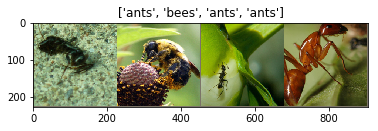

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model,criterion,optimizer,scheduler=lr_scheduler,epochs=25):
    start=time.time()
    
    model_b=copy.deepcopy(model.state_dict())
    acc_b=0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        for  phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            losses=0.0
            corres=0
            
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                losses += loss.item() * inputs.size(0)
                corres += torch.sum(preds == labels.data)

            epoch_loss = losses / dataset_sizes[phase]
            epoch_acc = corres.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > acc_b:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(acc_b))

    # load best model weights
    model.load_state_dict(model_b)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       epochs=25)

Epoch 0/24
----------
train Loss: 0.5969 Acc: 0.7131
val Loss: 0.3115 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4526 Acc: 0.8074
val Loss: 0.2816 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6476 Acc: 0.7746
val Loss: 0.2375 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5888 Acc: 0.7664
val Loss: 0.7705 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.5852 Acc: 0.7828
val Loss: 0.3670 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5234 Acc: 0.7746
val Loss: 0.4421 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.2756 Acc: 0.8934
val Loss: 0.2017 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2709 Acc: 0.8852
val Loss: 0.1823 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2707 Acc: 0.8893
val Loss: 0.2145 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3016 Acc: 0.8566
val Loss: 0.2088 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3007 Acc: 0.8648
val Loss: 0.1703 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3430 Acc: 0.8648
val Loss: 0.2149 Acc: 0.9085

Ep

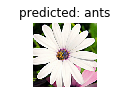

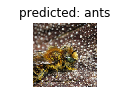

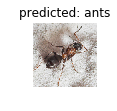

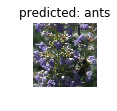

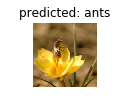

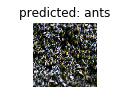

In [20]:
visualize_model(model_ft)

In [23]:
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False

ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(ftrs,2)
model_conv=model_conv.to(device)

criterion=nn.CrossEntropyLoss()

optimizer_conv=optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, epochs=25)

Epoch 0/24
----------
train Loss: 0.9800 Acc: 0.5533
val Loss: 0.3120 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4600 Acc: 0.7787
val Loss: 0.1605 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4181 Acc: 0.7869
val Loss: 0.2856 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.3687 Acc: 0.8402
val Loss: 0.1671 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.5207 Acc: 0.7869
val Loss: 0.2199 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3699 Acc: 0.8320
val Loss: 0.1670 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3719 Acc: 0.8320
val Loss: 0.1712 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3539 Acc: 0.8607
val Loss: 0.1886 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3636 Acc: 0.8197
val Loss: 0.2001 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3232 Acc: 0.8648
val Loss: 0.1877 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4241 Acc: 0.8033
val Loss: 0.1750 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3914 Acc: 0.8238
val Loss: 0.1704 Acc: 0.9477

Ep

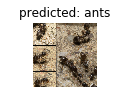

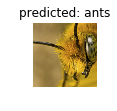

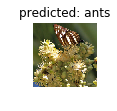

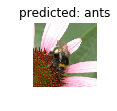

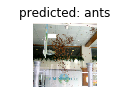

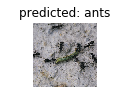

In [26]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [28]:
torch.cuda.empty_cache()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import os
import unicodedata
import numpy as np
import torch.optim as optim
from torchtext.datasets import TranslationDataset,Multi30k
from torchtext.data import Field,BucketIterator
device=torch.device('cuda:0')
import spacy
import random
import math
import time

In [2]:
SEED=1024

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

In [3]:
#!python -m spacy download en
#!python -m spacy download de

In [4]:
spacy_de=spacy.load('de')
spacy_en=spacy.load('en')

In [5]:
def token_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]
def token_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


In [6]:
SRC=Field(tokenize=token_de,init_token='<sos>',eos_token='<eos>',lower=True)
TRG=Field(tokenize=token_en,init_token='<sos>',eos_token='<eos>',lower=True)
train_data,valid_data,test_data=Multi30k.splits(exts=('.de','.en'),fields=(SRC,TRG))

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [7]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [8]:
SRC.build_vocab(train_data,min_freq=2)
TRG.build_vocab(train_data,min_freq=2)
print(len(SRC.vocab))
print(len(TRG.vocab))

7855
5893


In [9]:
device

device(type='cuda', index=0)

In [10]:
BATCH_SIZE=128
train_iter,valid_iter,test_iter=BucketIterator.splits((train_data,valid_data,test_data),batch_size=BATCH_SIZE,device=device)
print(train_iter)

In [20]:
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,n_layers,dropout):
        super().__init__()
        
        self.input_dim=input_dim
        self.emb_dim=emb_dim
        self.hid_dim=hid_dim
        self.n_layers=n_layers
        self.dropout=dropout
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,src):
        embedded=self.dropout(self.embedding(src))
        
        outputs,(hidden,cell)=self.rnn(embedded)
        
        return hidden,cell
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,hid_dim,n_layers,dropout):
        super().__init__()
        
        self.emb_dim=emb_dim
        self.hid_dim=hid_dim
        self.output_dim=output_dim
        self.n_layers=n_layers
        self.dropout=dropout
        
        self.embedding=nn.Embedding(output_dim,emb_dim)
        
        self.rnn=nn.LSTM(emb_dim,hid_dim,n_layers,dropout=dropout)
        
        self.out=nn.Linear(hid_dim,output_dim)
        
        self.dropout=nn.Dropout(dropout)
    def forward(self,inputs,hidden,cell):
        inputs=inputs.unsqueeze(0)
        embedded=self.dropout(self.embedding(inputs))
        
        output,(hidden,cell)=self.rnn(embedded,(hidden,cell))
        
        prediction=self.out(output.squeeze(0))
        
        return prediction,hidden,cell
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        self.device=device
        
        assert encoder.hid_dim==decoder.hid_dim,\
            "编码层和解码层隐藏层必须相同"
        assert encoder.n_layers==decoder.n_layers,\
            "编码器解码器层数必须相同"
    def forward(self,src,trg,teacher_forcing_ratio=0.5):
        
        batch_size=trg.shape[1]
        max_len=trg.shape[0]
        
        trg_vacab_size=self.decoder.output_dim
        
        outputs=torch.zeros(max_len,batch_size,trg_vacab_size).to(self.device)
        
        hidden,cell=self.encoder(src)
        
        inputs=trg[0,:]
        
        for t in range(1,max_len):
            output,hidden,cell=self.decoder(inputs,hidden,cell)
            outputs[t]=output
            teacher_forcing=random.random()<teacher_forcing_ratio
            top1=output.max(1)[1]
            inputs=(trg[t] if teacher_forcing else top1)
            
        return outputs

In [21]:
input_dim=len(SRC.vocab)
output_dim=len(TRG.vocab)

encode_emb_dim=256
decode_emb_dim=256

hid_dim=512
n_layers=2

enc_dropout=0.5
dec_dropout=0.5

enc=Encoder(input_dim,encode_emb_dim,hid_dim,n_layers,enc_dropout)
dec=Decoder(output_dim,decode_emb_dim,hid_dim,n_layers,dec_dropout)

model=Seq2Seq(enc,dec,device).to(device)


In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,899,013 trainable parameters


In [24]:
optims=optim.Adam(model.parameters())
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src,trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optims, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 29s
	Train Loss: 5.050 | Train PPL: 156.027
	 Val. Loss: 4.911 |  Val. PPL: 135.710
Epoch: 02 | Time: 0m 29s
	Train Loss: 4.480 | Train PPL:  88.278
	 Val. Loss: 4.725 |  Val. PPL: 112.692
Epoch: 03 | Time: 0m 29s
	Train Loss: 4.197 | Train PPL:  66.459
	 Val. Loss: 4.609 |  Val. PPL: 100.400
Epoch: 04 | Time: 0m 29s
	Train Loss: 3.990 | Train PPL:  54.061
	 Val. Loss: 4.408 |  Val. PPL:  82.145
Epoch: 05 | Time: 0m 29s
	Train Loss: 3.826 | Train PPL:  45.880
	 Val. Loss: 4.370 |  Val. PPL:  79.009
Epoch: 06 | Time: 0m 29s
	Train Loss: 3.692 | Train PPL:  40.140
	 Val. Loss: 4.268 |  Val. PPL:  71.385
Epoch: 07 | Time: 0m 29s
	Train Loss: 3.556 | Train PPL:  35.031
	 Val. Loss: 4.216 |  Val. PPL:  67.771
Epoch: 08 | Time: 0m 30s
	Train Loss: 3.422 | Train PPL:  30.627
	 Val. Loss: 4.168 |  Val. PPL:  64.560
Epoch: 09 | Time: 0m 29s
	Train Loss: 3.299 | Train PPL:  27.091
	 Val. Loss: 4.065 |  Val. PPL:  58.245
Epoch: 10 | Time: 0m 29s
	Train Loss: 3.188 | Train PPL

In [ ]:
class Encoder_1(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,dropout):
        super().__init__()
        
        self.input_dim=input_dim
        self.emb_dim=emb_dim
        self.hid_dim=hid_dim
        self.dropout=dropout
        
        self.embedding=nn.Embedding(input_dim,emb_dim)
        
        self.rnn=nn.GRU(emb_dim,hid_dim)
        
        self.dropout=nn.Dropout(dropout)
    def forward(self,src):
        
        
        embedded=self.dropout(self.embedding(src))
        
        outputs,hidden=self.rnn(embedded)
        
        return hidden
class Decoder_1(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,dropout):
    def forward(self,)